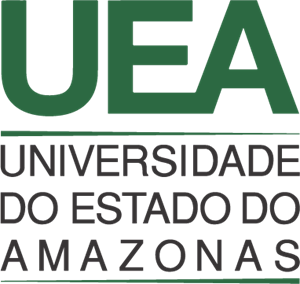

- Módulo: Ciência de Dados para Negócios

- Alunos:
  
  - Andrew da Silva Santos
  - Eberth Felipe Castro da Cruz
  - Eduardo Amorim de Araújo




#Coding

##General Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, SCORERS
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.utils import resample

# Configs
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

import pickle

Install Extra Libraries

In [4]:
# install
!pip install shap
!pip install xgboost==1.5.1
!pip install catboost
!pip install lightgbm

import xgboost
import catboost
import lightgbm as lgb

     |████████████████████████████████| 564 kB 10.4 MB/s 
     |████████████████████████████████| 173.5 MB 11 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
     |████████████████████████████████| 76.3 MB 63 kB/s 


##Get data from Kaggle API
Reference: https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb

###Install Kaggle and Import API

In [5]:
!pip install kaggle

###Get Files

In [6]:
# Kaggle API reference: https://github.com/Kaggle/kaggle-api
def import_kaggle_api_key():
  from google.colab import files

  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
  # Then move kaggle.json into the folder where the API expects to find it.
  !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
  from kaggle.api.kaggle_api_extended import KaggleApi

def get_data_from_competition():
  # Kaggle competition link
  # https://www.kaggle.com/c/homesite-quote-conversion
  !kaggle competitions download -c homesite-quote-conversion --force
  !unzip ./test.csv.zip
  !unzip ./train.csv.zip
  !unzip ./sample_submission.csv.zip
  !ls -la ./

In [7]:
import_kaggle_api_key()

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [8]:
get_data_from_competition()

 89% 22.0M/24.7M [00:00<00:00, 41.9MB/s]
100% 24.7M/24.7M [00:00<00:00, 82.1MB/s]
  0% 0.00/258k [00:00<?, ?B/s]
100% 258k/258k [00:00<00:00, 70.8MB/s]
100% 37.0M/37.1M [00:00<00:00, 49.9MB/s]
100% 37.1M/37.1M [00:00<00:00, 63.2MB/s]
Archive:  ./test.csv.zip
  inflating: test.csv                
Archive:  ./train.csv.zip
  inflating: train.csv               
Archive:  ./sample_submission.csv.zip
  inflating: sample_submission.csv   
total 402160
drwxr-xr-x 1 root root      4096 Dec 16 22:25 .
drwxr-xr-x 1 root root      4096 Dec 16 22:20 ..
drwxr-xr-x 4 root root      4096 Dec  3 14:33 .config
drwxr-xr-x 1 root root      4096 Dec  3 14:33 sample_data
-rw-r--r-- 1 root root   1520192 Nov  4  2015 sample_submission.csv
-rw-r--r-- 1 root root    264355 Dec 16 22:25 sample_submission.csv.zip
-rw-r--r-- 1 root root 137849053 Nov  4  2015 test.csv
-rw-r--r-- 1 root root  25927745 Dec 16 22:25 test.csv.zip
-rw-r--r-- 1 root root 207278432 Nov  4  2015 train.csv
-rw-r--r-- 1 root root  3893918

###Initial view

In [9]:
df_dados_teste = pd.read_csv('./test.csv')
df_dados_treino = pd.read_csv('./train.csv')
df_template_sub = pd.read_csv('./sample_submission.csv')

#Utils

In [10]:
def explore_dataset(df_aux):
  delimiter = '--------------------'
  print(df_aux.shape)
  print(delimiter)
  print(round(df_aux.describe(), 2))
  print(delimiter)
  df_aux.info(verbose=True)

def plot_target_distribution(df_aux):
  print(df_aux['QuoteConversion_Flag'].value_counts())
  plt.figure(figsize = (6,4))
  plt.margins(.2)
  ax = sns.countplot(x = 'QuoteConversion_Flag', 
                    data = df_aux)
  x_labels = ['Não', 'Sim']
  ax.set_xticklabels(x_labels)
  ax.set_title('Cotações de seguro de Casa')
  ax.set_xlabel('Cotações')
  ax.set_ylabel('Qtd. de cotações')
  # plt.xticks(rotation=45)
  add_value_labels(ax)
  plt.show() 

def add_value_labels(ax, spacing=5):
    # reference: https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """
    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        label = "{:1.1f}K".format(y_value*0.001)
        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

#Transform fields from Object to int
def transform_fields(df, fields):
  label_encoder = LabelEncoder()
  for field in fields:
    df[field] = label_encoder.fit_transform(list(df[field].values))
  return df

def fill_na_values(df, value):
  return df.fillna(value)

def split_data_for_xy_columns(df, col_begin, col_end, target):
  split_X = df.loc[:,col_begin:col_end]
  split_y = df.loc[:,target]
  return split_X, split_y 

# Reference: https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
# Feature Importance
def get_columns_by_importance(X, y, number_col):
  model = ExtraTreesClassifier()
  model.fit(X,y)
  #use inbuilt class feature_importances of tree based classifiers
  # print(model.feature_importances_)
  #plot graph of feature importances for better visualization
  feat_importances = pd.Series(model.feature_importances_, index=X.columns)
  columns = feat_importances.nlargest(number_col)
  columns.plot(kind='barh')
  plt.show()
  return columns.index

def get_samples_for_train_test(X, y, div_size, random):
  X_tr, X_ts, y_tr, y_ts = train_test_split(X, 
                                            y,
                                            shuffle = True,
                                            stratify = y,
                                            test_size=div_size, 
                                            random_state=random)
  print('Amostras de treino:')
  print(f' * X_train: {X_tr.shape}')
  print(f' * y_train: {y_tr.shape}')

  print('Amostras de teste:')
  print(f' * X_test: {X_ts.shape}')
  print(f' * y_test: {y_ts.shape}')
  return X_tr, X_ts, y_tr, y_ts

def create_cross_validation_model(model, num_splits, scoring_metric, X_tr, y_tr):
  cv = KFold(n_splits = num_splits, 
            shuffle = True, 
            random_state=0)
  n_scores = cross_val_score(model, 
                            X_tr, y_tr, 
                            scoring = scoring_metric, 
                            cv = cv)
  print_cross_model_result(n_scores, scoring_metric)
  return model

def print_cross_model_result(n_scores, scoring_metric):
  print('Cross Validation Result\n')
  print(f'{scoring_metric}: {n_scores}\n')
  print(f'{scoring_metric} (média): {round(np.mean(n_scores), 4)}')
  print(f'{scoring_metric} (desvio padrão): {round(np.std(n_scores), 4)}')


def print_model_result(model, X_tr, X_ts, y_tr, y_ts):
  print(f'Acurácia (Treino): {round(accuracy_score(y_tr, model.predict(X_tr)), 2)}')
  print(f'Acurácia (Teste): {round(accuracy_score(y_ts, model.predict(X_ts)), 2)}')
  print(classification_report(y_ts, model.predict(X_ts), target_names=['NO', 'YES']))
  plot_confusion_matrix(model, X_ts, y_ts)
  
def validate_ens_model(model, X_tr, X_ts, y_tr, y_ts):
  print('### fit model ###')
  model.fit(X_tr, y_tr)
  print('### Result: ###')
  print_model_result(model, X_tr, X_ts, y_tr, y_ts)
  return model

def plot_confusion_matrix(model, X_ts, y_ts):
  fig, ax = plt.subplots(figsize=(10,8))
  cm = confusion_matrix(y_ts, model.predict(X_ts), labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=pd.Series(model.classes_).map({0: 'No', 1: 'Yes'}))
  disp.plot(cmap=plt.cm.Blues, ax=ax)
  plt.show()

def plot_correlation_matrix(df):
  fig, ax = plt.subplots(figsize=(14,14))
  corr = df.corr()
  plot = sns.heatmap(corr, annot = True, fmt=".1f", linewidths=.6, ax=ax)
  plot

def save_model(model):
  # save the model to disk
  filename = 'model.pkl'
  pickle.dump(model, open(filename, 'wb'))


Dados de Treino

In [11]:
df_dados_treino.head()

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField3,SalesField4,SalesField5,SalesField6,SalesField7,SalesField8,SalesField9,SalesField10,SalesField11,SalesField12,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField4A,PersonalField4B,PersonalField5,PersonalField6,PersonalField7,PersonalField8,PersonalField9,PersonalField10A,PersonalField10B,PersonalField11,PersonalField12,PersonalField13,PersonalField14,PersonalField15,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,PersonalField31,PersonalField32,PersonalField33,PersonalField34,PersonalField35,PersonalField36,PersonalField37,PersonalField38,PersonalField39,PersonalField40,PersonalField41,PersonalField42,PersonalField43,PersonalField44,PersonalField45,PersonalField46,PersonalField47,PersonalField48,PersonalField49,PersonalField50,PersonalField51,PersonalField52,PersonalField53,PersonalField54,PersonalField55,PersonalField56,PersonalField57,PersonalField58,PersonalField59,PersonalField60,PersonalField61,PersonalField62,PersonalField63,PersonalField64,PersonalField65,PersonalField66,PersonalField67,PersonalField68,PersonalField69,PersonalField70,PersonalField71,PersonalField72,PersonalField73,PersonalField74,PersonalField75,PersonalField76,PersonalField77,PersonalField78,PersonalField79,PersonalField80,PersonalField81,PersonalField82,PersonalField83,PersonalField84,PropertyField1A,PropertyField1B,PropertyField2A,PropertyField2B,PropertyField3,PropertyField4,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField16A,PropertyField16B,PropertyField17,PropertyField18,PropertyField19,PropertyField20,PropertyField21A,PropertyField21B,PropertyField22,PropertyField23,PropertyField24A,PropertyField24B,PropertyField25,PropertyField26A,PropertyField26B,PropertyField27,PropertyField28,PropertyField29,PropertyField30,PropertyField31,PropertyField32,PropertyField33,PropertyField34,PropertyField35,PropertyField36,PropertyField37,PropertyField38,PropertyField39A,PropertyField39B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField5A,GeographicField5B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField10A,GeographicField10B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A,GeographicField13B,GeographicField14A,GeographicField14B,GeographicField15A,GeographicField15B,GeographicField16A,GeographicField16B,GeographicField17A,GeographicField17B,GeographicField18A,GeographicField18B,GeographicField19A,GeographicField19B,GeographicField20A,GeographicField20B,GeographicField21A,GeographicField21B,GeographicField22A,GeographicField22B,GeographicField23A,GeographicField23B,GeographicField24A,GeographicField24B,GeographicField25A,GeographicField25B,GeographicField26A,GeographicField26B,GeographicField27A,GeographicField27B,GeographicField28A,GeographicField28B,GeographicField29A,GeographicField29B,GeographicField30A,GeographicField30B,GeographicField31A,GeographicField31B,GeographicField32A,GeographicField32B,GeographicField33A,GeographicField33B,GeographicField34A,GeographicField34B,GeographicField35A,GeographicField35B,GeographicField36A,GeographicFie

0    211859
1     48894
Name: QuoteConversion_Flag, dtype: int64


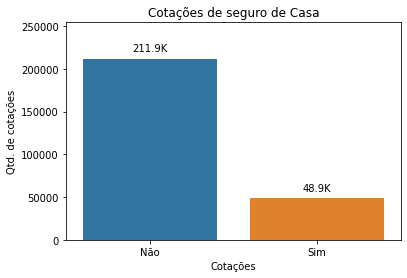

In [12]:
plot_target_distribution(df_dados_treino)

## Aumentando Classe **Minoritária**

Escoha a quantidade de pacientes diabéticos para treinamento dos modelos

In [14]:
#@title Quantidade Cotações realizadas: SIM
max_num_diabetes =  80000#@param {type:"integer"}

# ref: https://elitedatascience.com/imbalanced-classes

# Separate majority and minority classes
df_majority = df_dados_treino[df_dados_treino['QuoteConversion_Flag'] == 0]
df_minority = df_dados_treino[df_dados_treino['QuoteConversion_Flag'] == 1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples=max_num_diabetes,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])
 
# Display new class counts
print(df_upsampled['QuoteConversion_Flag'].value_counts())
df_dados_treino = df_upsampled

0    211859
1     80000
Name: QuoteConversion_Flag, dtype: int64


0    211859
1     80000
Name: QuoteConversion_Flag, dtype: int64


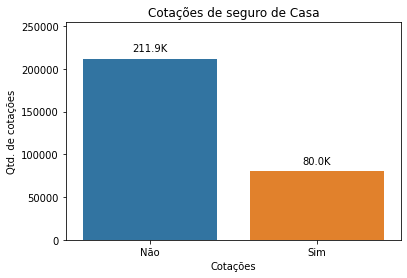

In [15]:
plot_target_distribution(df_dados_treino)

##Remove columns

In [16]:
rm_columns = [ 'Original_Quote_Date' ]

df_dados_teste.drop(columns=rm_columns, inplace=True)
df_dados_treino.drop(columns=rm_columns, inplace=True)

##ETL

In [15]:
explore_dataset(df_dados_treino)

(291859, 298)
--------------------
       QuoteNumber  QuoteConversion_Flag     Field7     Field8    Field9  \
count    291859.00             291859.00  291859.00  291859.00  291859.0   
mean     217238.95                  0.27      18.07       0.94       0.0   
std      125544.21                  0.45       7.46       0.04       0.0   
min           1.00                  0.00       1.00       0.87       0.0   
25%      108502.50                  0.00      11.00       0.92       0.0   
50%      217047.00                  0.00      23.00       0.94       0.0   
75%      326123.00                  1.00      24.00       0.97       0.0   
max      434588.00                  1.00      28.00       1.01       0.0   

         Field11  CoverageField1A  CoverageField1B  CoverageField2A  \
count  291859.00        291859.00        291859.00        291859.00   
mean        1.16             8.91            12.88             8.96   
std         0.12             5.51             7.19             5.50

In [17]:
fields_to_tranform = [
                      'Field6',
                      'Field10',
                      'Field12',
                      'CoverageField8',
                      'CoverageField9',
                      'SalesField7',
                      'PersonalField7',
                      'PersonalField16',
                      'PersonalField17',
                      'PersonalField18',
                      'PersonalField19',
                      'PropertyField3',
                      'PropertyField4',
                      'PropertyField5',
                      'PropertyField7',
                      'PropertyField14',
                      'PropertyField28',
                      'PropertyField30',
                      'PropertyField31',
                      'PropertyField32',
                      'PropertyField33',
                      'PropertyField34',
                      'PropertyField36',
                      'PropertyField37',
                      'PropertyField38',
                      'GeographicField63',
                      'GeographicField64'
                      ]
                      
df_dados_teste = transform_fields(df_dados_teste, fields_to_tranform)
df_dados_treino = transform_fields(df_dados_treino, fields_to_tranform)

In [18]:
# fill na with median
df_dados_treino = fill_na_values(df_dados_treino, df_dados_treino.median())
df_dados_teste = fill_na_values(df_dados_teste, df_dados_teste.median())

In [19]:
#Check fields in dataset before run
X, y = split_data_for_xy_columns(df_dados_treino,'Field6', 'GeographicField64', target='QuoteConversion_Flag')

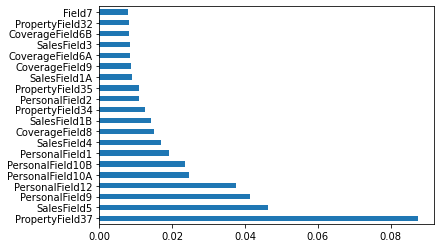

In [20]:
columns_important = get_columns_by_importance(X, y, 20)

In [21]:
list_aux = columns_important.values.tolist()
list_aux.insert(0,'QuoteNumber')
print(len(list_aux))

df_dados_teste = df_dados_teste.loc[:, df_dados_teste.columns.isin(list_aux)]

list_aux.insert(len(list_aux), 'QuoteConversion_Flag')
print(len(list_aux))
df_dados_treino = df_dados_treino.loc[:, df_dados_treino.columns.isin(list_aux)]
print(df_dados_treino.shape) 

21
22
(291859, 22)


In [22]:
df_dados_treino.head()

,QuoteNumber,QuoteConversion_Flag,Field7,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,SalesField1A,SalesField1B,SalesField3,SalesField4,SalesField5,PersonalField1,PersonalField2,PersonalField9,PersonalField10A,PersonalField10B,PersonalField12,PropertyField32,PropertyField34,PropertyField35,PropertyField37
134742,224247,1,1,1,6,0,10,3,7,1,3,4,1,1,2,25,25,1,1,0,2,0
222358,370590,1,26,13,23,5,5,10,21,1,3,4,1,1,2,5,8,1,1,0,2,1
211329,352243,1,24,13,23,5,4,1,1,1,4,3,1,1,2,6,9,1,1,1,2,1
3460,5771,1,24,1,6,5,4,3,6,1,1,2,1,1,2,4,3,3,1,1,2,1
56230,93601,1,11,13,23,5,4,7,18,0,3,4,1,0,2,5,6,2,1,1,2,1


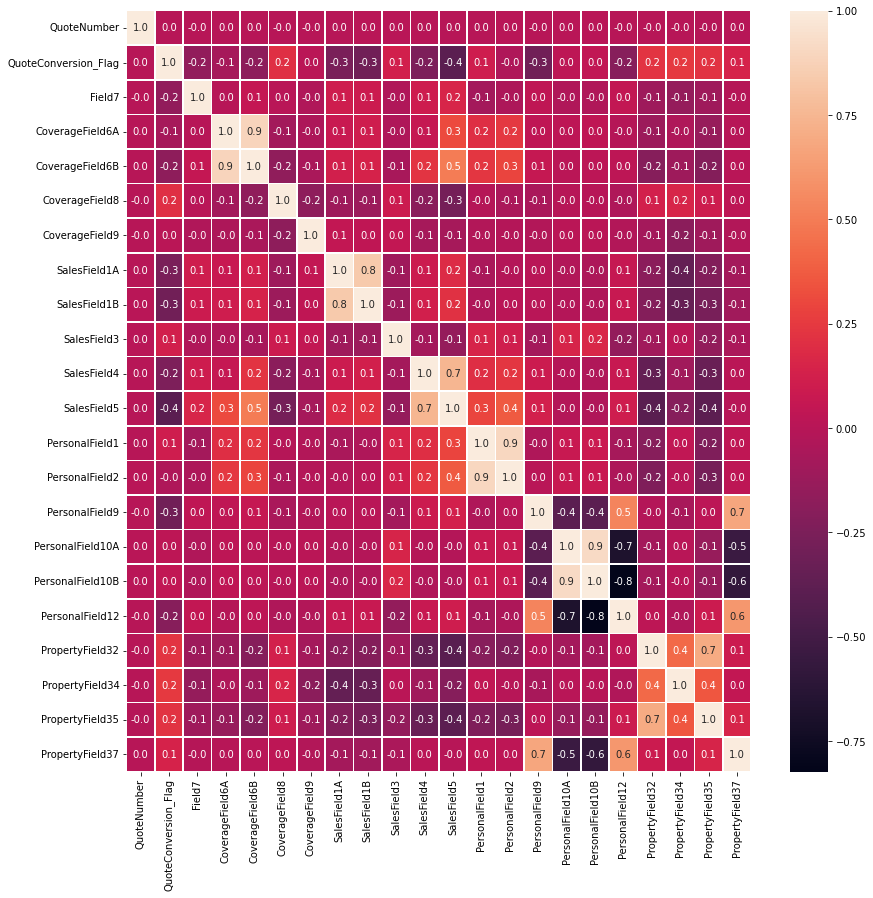

In [23]:
plot_correlation_matrix(df_dados_treino)

#Machine Learning Algorithms

In [24]:
X, y = split_data_for_xy_columns(df_dados_treino,'CoverageField6B', 'PropertyField37', target='QuoteConversion_Flag')
X_train, X_test, y_train, y_test = get_samples_for_train_test(X, y, div_size=0.30, random=1)

Amostras de treino:
 * X_train: (204301, 18)
 * y_train: (204301,)
Amostras de teste:
 * X_test: (87558, 18)
 * y_test: (87558,)


##XGBoost

In [25]:
from sklearn.metrics import roc_curve

In [26]:
work_metric = "roc_auc"

# xgb_model = xgboost.XGBClassifier(booster = 'gbtree', 
#                                   learning_rate = 0.005,
#                                   n_estimators = 100,
#                                   max_depth = 15,
#                                   random_state = 0)

train = xgboost.DMatrix(X_train,y_train,
                feature_names=X_train.columns)
test = xgboost.DMatrix(X_test,feature_names=X_train.columns)
xgb_params = {
              'eta':0.03,
              'max_depth':15,
              'sub_sample':0.9,
              'colsample_bytree':0.5,
              'objective':'binary:hinge',
              'eval_metric':'auc',
              'silent':0
              }
print('****************** XGBoost ******************')
xgb_model = xgboost.train(xgb_params,train,num_boost_round=500)
# xgb_model = create_cross_validation_model(xgb_model, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** XGBoost ******************
[22:30:53] WARNING: ../src/learner.cc:576: 
Parameters: { "silent", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [27]:
# xgb_model = validate_ens_model(xgb_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)
# print_model_result(model=xgb_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

y_pred_train = xgb_model.predict(train)
y_pred_train

array([0., 1., 0., ..., 0., 0., 1.], dtype=float32)

In [50]:
roc_curve(y_pred_train, y_train)

(array([0.       , 0.0253802, 1.       ]),
 array([0.        , 0.95642933, 1.        ]),
 array([2, 1, 0]))

In [32]:
save_model(xgb_model)

## Random Forest

In [ ]:
def create_ens_random_forest(depth, estimators):
  model = RandomForestClassifier(n_estimators=estimators, 
                                  criterion='entropy',
                                  max_depth=depth,
                                  min_samples_split=2,
                                  random_state=0)
  return model

In [ ]:
ens_random_forest_model = create_ens_random_forest(16, 100)
print('****************** Random Forest ******************')
ens_random_forest_model = create_cross_validation_model(ens_random_forest_model, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** Random Forest ******************
Cross Validation Result

roc_auc: [0.95877072 0.95943128 0.95776005 0.95867694 0.95928871]

roc_auc (média): 0.9588
roc_auc (desvio padrão): 0.0006


### Fit model ###
### Result: ###
Acurácia (Treino): 0.91
Acurácia (Teste): 0.9
              precision    recall  f1-score   support

          NO       0.91      0.96      0.93     63558
         YES       0.87      0.75      0.81     24000

    accuracy                           0.90     87558
   macro avg       0.89      0.85      0.87     87558
weighted avg       0.90      0.90      0.90     87558



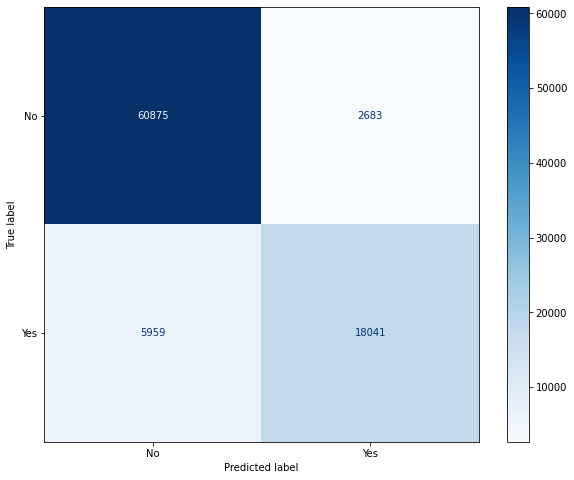

In [ ]:
ens_random_forest_model = validate_ens_model(ens_random_forest_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

## CatBoost

In [ ]:
 cat_boost_model = catboost.CatBoostClassifier(iterations=5,
                         learning_rate=0.025,
                         depth=15,
                         random_state=0)

In [ ]:
print('****************** CatBoost ******************')
cat_boost_model = create_cross_validation_model(cat_boost_model, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** CatBoost ******************
0:	learn: 0.6767163	total: 180ms	remaining: 719ms
1:	learn: 0.6608763	total: 259ms	remaining: 389ms
2:	learn: 0.6459976	total: 358ms	remaining: 239ms
3:	learn: 0.6319337	total: 607ms	remaining: 152ms
4:	learn: 0.6183043	total: 660ms	remaining: 0us
0:	learn: 0.6767392	total: 124ms	remaining: 494ms
1:	learn: 0.6609284	total: 203ms	remaining: 305ms
2:	learn: 0.6460684	total: 297ms	remaining: 198ms
3:	learn: 0.6319906	total: 484ms	remaining: 121ms
4:	learn: 0.6183903	total: 539ms	remaining: 0us
0:	learn: 0.6767325	total: 137ms	remaining: 550ms
1:	learn: 0.6609161	total: 218ms	remaining: 327ms
2:	learn: 0.6459489	total: 312ms	remaining: 208ms
3:	learn: 0.6318672	total: 502ms	remaining: 126ms
4:	learn: 0.6182481	total: 590ms	remaining: 0us
0:	learn: 0.6767024	total: 118ms	remaining: 473ms
1:	learn: 0.6609094	total: 199ms	remaining: 299ms
2:	learn: 0.6460573	total: 294ms	remaining: 196ms
3:	learn: 0.6319833	total: 499ms	remaining: 125ms
4:	learn:

### Fit model ###
0:	learn: 0.6774094	total: 231ms	remaining: 926ms
1:	learn: 0.6619760	total: 449ms	remaining: 673ms
2:	learn: 0.6469791	total: 516ms	remaining: 344ms
3:	learn: 0.6329940	total: 743ms	remaining: 186ms
4:	learn: 0.6193819	total: 976ms	remaining: 0us
### Result: ###
Acurácia (Treino): 0.89
Acurácia (Teste): 0.89
              precision    recall  f1-score   support

          NO       0.89      0.96      0.93     63558
         YES       0.88      0.69      0.77     24000

    accuracy                           0.89     87558
   macro avg       0.89      0.83      0.85     87558
weighted avg       0.89      0.89      0.89     87558



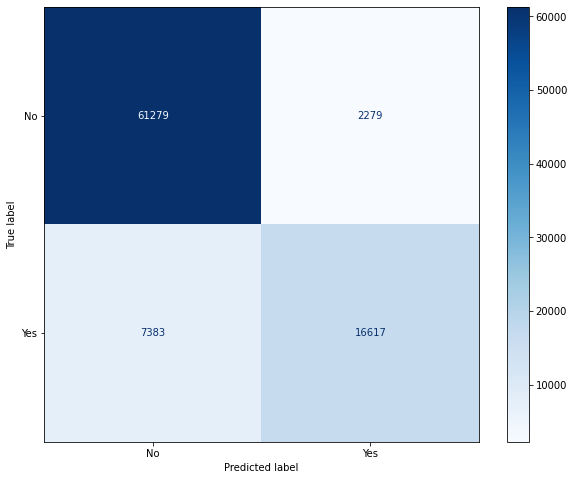

In [ ]:
cat_boost_model = validate_ens_model(cat_boost_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

#JSON

In [28]:
import json
dados = json.loads(X_test.iloc[0].to_json())
print(dados)

{'CoverageField6B': 23, 'CoverageField8': 0, 'CoverageField9': 10, 'SalesField1A': 21, 'SalesField1B': 25, 'SalesField3': 1, 'SalesField4': 5, 'SalesField5': 5, 'PersonalField1': 1, 'PersonalField2': 1, 'PersonalField9': 3, 'PersonalField10A': -1, 'PersonalField10B': -1, 'PersonalField12': 5, 'PropertyField32': 0, 'PropertyField34': 0, 'PropertyField35': 0, 'PropertyField37': 1}


In [30]:
colunas = ['CoverageField6B', 'CoverageField8',
       'CoverageField9', 'SalesField1A',
       'SalesField1B', 'SalesField3',
       'SalesField4', 'SalesField5',
       'PersonalField1', 'PersonalField2', 'PersonalField9', 'PersonalField10A',
       'PersonalField10B', 'PersonalField12', 'PropertyField32', 
       'PropertyField34', 'PropertyField35',
       'PropertyField37']

payload = [dados[col] for col in colunas]

Predict pelo modelo treinado

In [31]:
# test = pd.DataFrame(data=[payload], columns=colunas)
payload = xgboost.DMatrix([payload], feature_names=colunas)
print(xgb_model.predict(payload)[0])

0.0


Predict pelo modelo carregado

In [33]:
def load_model(file_name = 'model.pkl'):
    return pickle.load(open(file_name, "rb"))

modelo = load_model()

In [34]:
print(modelo.predict(payload)[0])

0.0
